# Intelligent Systems for Pattern Recognition (unipi)
# Lucchesi Nicolo'
---
## Assigment 1 - 3rd choice

>Perform image segmentation on one of the eight image thematic subsets. Note that each file has a name starting with a number from 1 to 8, which indicates the thematic subset, followed by the rest of the file name. I suggest to use image subsets “1_*” or “2_*”.  Use the normalized cut algorithm to perform image segmentation. You are welcome to confront the result with kmeans segmentation algorithm if you wish.

[Used dataset](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip) (from microsoft)

---
## Load dataset

In [4]:
import os
import cv2
from sklearn.cluster import KMeans
import numpy as np

In [74]:
dataset_dir = 'MSRC_ObjCategImageDatabase_v1'
image_subset_prefix = "1_"
images = {}
#import image subset by listing all images in dataset directory
for filename in os.listdir(dataset_dir):
    if filename.startswith(image_subset_prefix) and filename.endswith('_s.bmp'):
        images[filename] = cv2.imread(dataset_dir+os.sep+filename, cv2.IMREAD_COLOR)
        
# obtain dict filename-image matrix
print("Number of images: ", len(images))
print("Shape of images: ", images['1_11_s.bmp'].shape)

Number of images:  30
Shape of images:  (213, 320, 3)


____
# Normalized Cut

In short, the idea is to construct a graph out of image pixels, with nodes being the pixels themselves and the edges representing some measure of *affinity* between them; these weights on edges will be 0 for completely dissimilar pixels (in terms of color) and will have an increasingly higher value for similar pixels.
Once this graph, known as *RAG* (region adjacency graph) is built, we can perform the normalized cut algorithm, hoping to obtain _clusters_ of similar pixels, hence sets of disconnected *sub-graphs* obtained in a balanced way (e.g not favouring single nodes subgraphs).

In [9]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline


img = images['1_11_s.bmp']

In [16]:
# define a simple function for displaying results 
def display_imgs(rows: int, cols: int, images: list, original_imgs: list):
    figure(num=None, figsize=(18, 14), dpi=80, facecolor='w', edgecolor='k')
    
    for i, _image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if (i % cols) == 1: # original images on left column
            plt.imshow(cv2.cvtColor(original_imgs[i], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(cv2.cvtColor(_image, cv2.COLOR_BGR2RGB))
        plt.xticks([]), plt.yticks([])
        
    plt.show()
        

## Pre-segmentantion: SLIC(Simple Linear Iterative Clustering) method for obtaining Superpixels

>It uses kmeans clustering technique exploiting *both RGB pixel values and position*; 
n_segments specifies number of Superpixels to obtain ([more_info](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic))
here we also run the 0-param version of SLIC, [SLIC0](https://ivrl.epfl.ch/research-2/research-current/research-superpixels/).

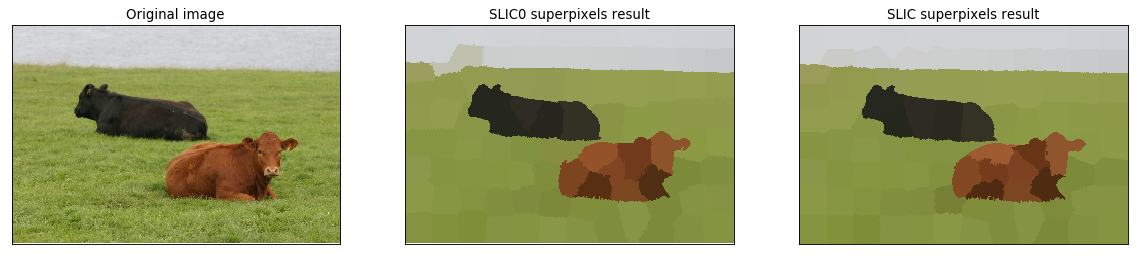

In [142]:
# return labels linking each pixel to a superpixel 'patch'
labels_slic0 = segmentation.slic(img, slic_zero=True)

# replace each pixel region with its avg color
superpixels_slic0 = color.label2rgb(labels_slic0, img, kind='avg')

# do same thing with SLIC parameterized version
labels_slic = segmentation.slic(img, compactness=30, n_segments=100)
superpixels_slic = color.label2rgb(labels_slic, img, kind='avg')

# show results 
figure(num=None, figsize=(18, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(superpixels_slic0, cv2.COLOR_BGR2RGB))
plt.title("SLIC0 superpixels result")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(superpixels_slic, cv2.COLOR_BGR2RGB))
plt.title("SLIC superpixels result")
plt.xticks([]), plt.yticks([])
plt.show()
#display_imgs(1, 3, [superpixels_slic0, superpixels_slic], [img])

>Display a comparison between RAG built from SLIC0 and SLIC superpixels

RAG on superpixels (SLIC0) takes:  0.7781267166137695 s


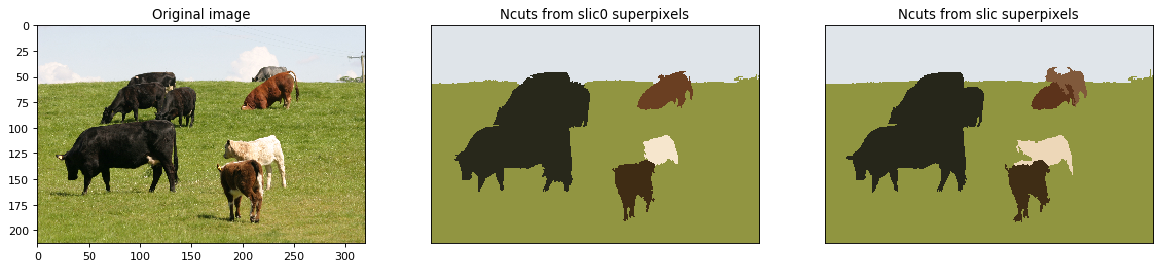

In [24]:
import time
# compute RAG on SuperPixels using mean colors
t0 = time.time()
g = graph.rag_mean_color(img, labels_slic0, mode='similarity')
ncuts_labels_slic0 = graph.cut_normalized(labels_slic0, g)
t1 = time.time()
print("RAG on superpixels (SLIC0) takes: ", (t1-t0),"s")

# replace each pixel region with its average color ('centroid')
ncuts_result_slic0 = color.label2rgb(ncuts_labels_slic0, img, kind='avg')

# bad idea! don't try it at home
# build RAG using slic superpixels
# fake_labels = np.arange(img.shape[0]*img.shape[1]).reshape((img.shape[0],img.shape[1]))
# t0 = time.time()
# g = graph.rag_mean_color(img, fake_labels, mode='similarity')
# ncuts_labels_whole = graph.cut_normalized(fake_labels, g)
# t1 = time.time()
# print("RAG on every pixels takes: ", (t1-t0))

# build rag and apply ncut algorithm 
g = graph.rag_mean_color(img, labels_slic, mode='similarity')
ncuts_labels_slic = graph.cut_normalized(labels_slic, g)
# replace each pixel region with its average color ('centroid')
ncuts_result_slic = color.label2rgb(ncuts_labels_slic, img, kind='avg')

# show results
# TODO factor this in a function
figure(num=None, figsize=(18, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image")


plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(ncuts_result_slic0, cv2.COLOR_BGR2RGB))
plt.title("Ncuts from slic0 superpixels")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(ncuts_result_slic, cv2.COLOR_BGR2RGB))
plt.title("Ncuts from slic superpixels")
plt.xticks([]), plt.yticks([])


plt.show()

# Apply n-cuts algorithm to whole thematic subset
---

In [75]:
ncut_images = []
for k, img in images.items():
    # first obtain superpixeled-image
    labels_slic = segmentation.slic(img, compactness=30, n_segments=100)
    # for printing superpixeled image
    superpixels_slic = color.label2rgb(labels_slic, img, kind='avg')
    
    # build rag (graph) out of the superpixeled image labels
    g = graph.rag_mean_color(img, labels_slic, mode='similarity')
    # apply ncut algorithm to graph
    ncuts_labels = graph.cut_normalized(labels_slic, g)
    # replace each pixel region with its average color ('centroid')
    ncuts_result = color.label2rgb(ncuts_labels, img, kind='avg')
    
    # save result
    ncut_images.append(ncuts_result)

`Display results`

In [76]:
len(images)

30

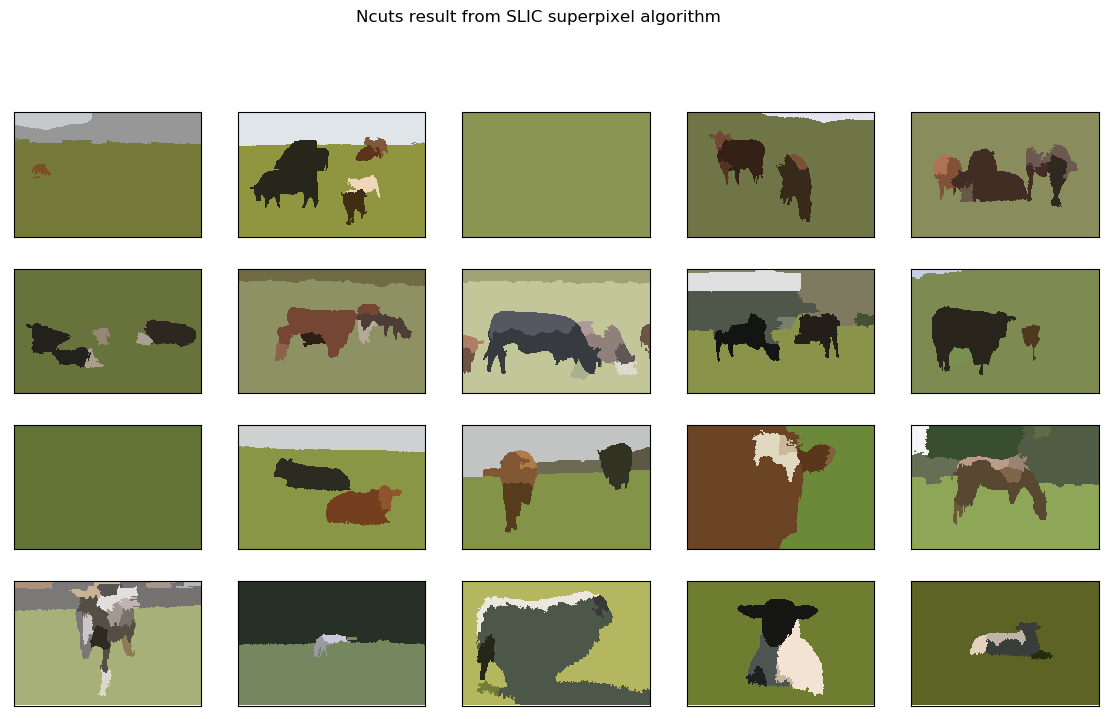

In [131]:
figure(num=None, figsize=(14, 10), dpi=100, facecolor='w', edgecolor='k').suptitle("Ncuts result from SLIC superpixel algorithm")

for i, _img in enumerate(ncut_images):
    if i>19:
        break
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])


`Display images comparison`

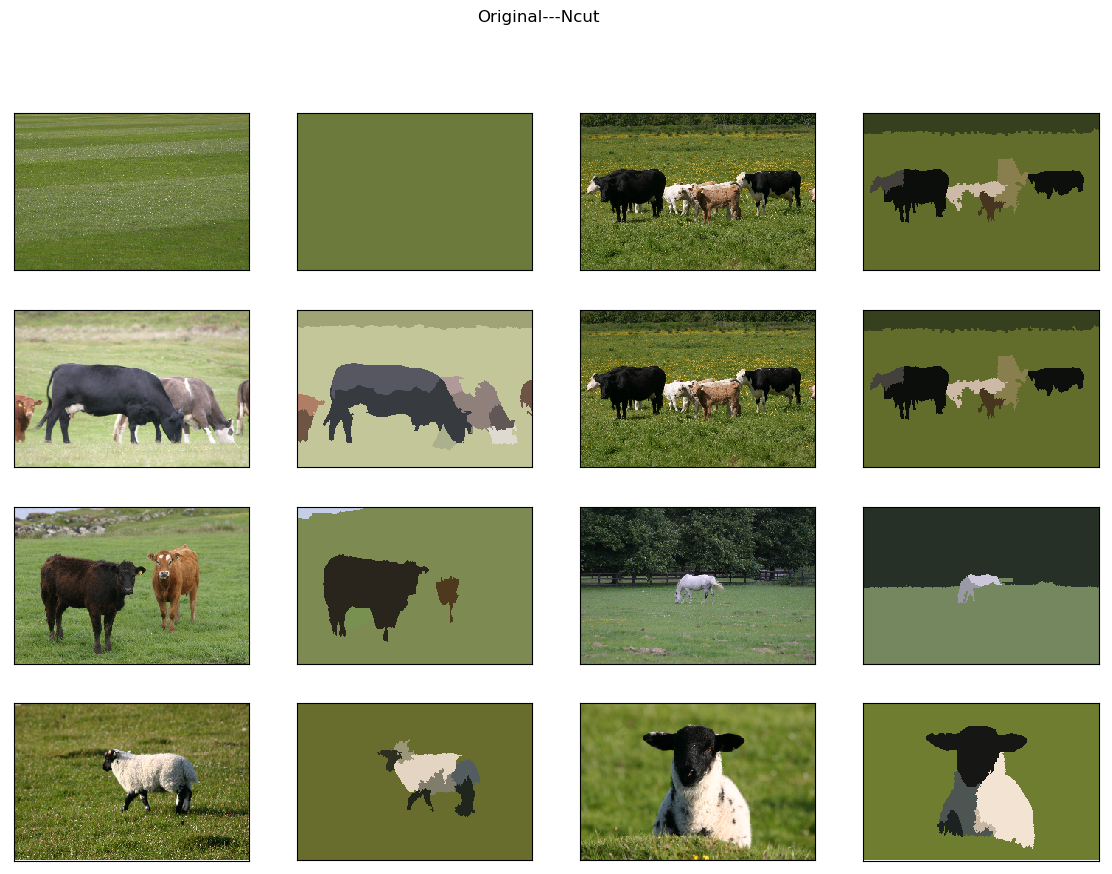

In [132]:
import random
figure(num=None, figsize=(14, 10), dpi=100, facecolor='w', edgecolor='k').suptitle("Original---Ncut")
dim = 4
original = list(images.values())
for i in range(0, dim*dim, 2):
    r = random.randint(0, len(images)-1)
    plt.subplot(dim, dim, i+1)
    plt.imshow(cv2.cvtColor(original[r], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(dim, dim, i+2)
    plt.imshow(cv2.cvtColor(ncut_images[r], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])


# Compare to kmeans 
Compare n-cuts result to kmeans, by providing kmeans with a 'golden' k value.
Also introduce "iterative" version of kmeans, hoping to *smooth* results; this is achieved by simply applying kmeans multiple times, each time considering image obtained from previous iteration.

`Before applying kmeans we build a matrix with shape=#pixel-RGB values, this is like moving a single pixel
in a space where each coordinate is expressed in terms of RED, GREEN and BLUE values`

25
20
15
10
5


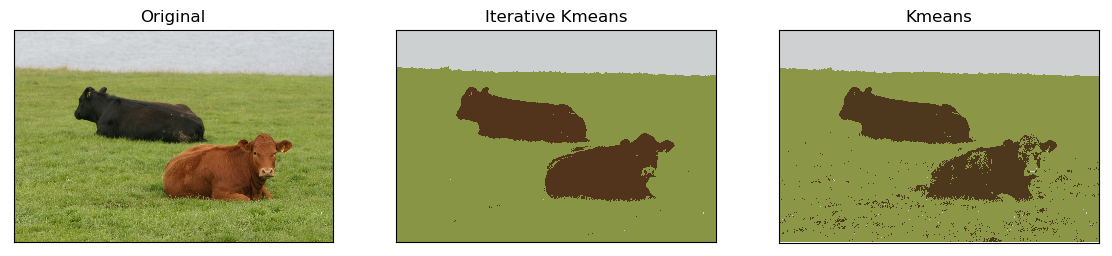

In [140]:
img = images['1_20_s.bmp']
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
figure(num=None, figsize=(14, 10), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# apply kmeans 'some' number of times (empirically evaluated)
for k in range(25, 4, -5):
    print(k)
    kmeans = KMeans(n_clusters=k, n_init=5, verbose=0, n_jobs=-1).fit(img.reshape(-1, 3))
    kmeans_result = color.label2rgb(kmeans.labels_.reshape(img.shape[0], -1), img, kind='avg')
    img = kmeans_result    
kmeans = KMeans(n_clusters=3, n_init=5, verbose=0, n_jobs=-1).fit(img.reshape(-1, 3))
kmeans_result = color.label2rgb(kmeans.labels_.reshape(img.shape[0], -1), img, kind='avg')
plt.subplot(1, 3, 2)
plt.title("Iterative Kmeans")
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2RGB))

## simple kmeans result
img = images['1_20_s.bmp']
kmeans = KMeans(n_clusters=3, n_init=10, verbose=0, n_jobs=-1).fit(img.reshape(-1, 3))
kmeans_result = color.label2rgb(kmeans.labels_.reshape(img.shape[0], -1), img, kind='avg')
plt.subplot(1, 3, 3)
plt.title("Kmeans")
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2RGB))
plt.show()

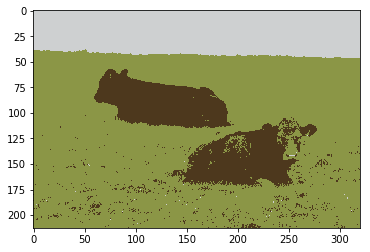

In [127]:
img = images['1_20_s.bmp']
kmeans = KMeans(n_clusters=3, n_init=2, verbose=0, n_jobs=-1).fit(img.reshape(-1, 3))
kmeans_result = color.label2rgb(kmeans.labels_.reshape(img.shape[0], -1), img, kind='avg')
plt.imshow(cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2RGB))


In [90]:
from sklearn.cluster import KMeans 

# let's organize data in a matrix containing (#pixel - RGB value)
imageRGB_matrix = {}
for k, v in images.items():
    imageRGB_matrix[k] = v.reshape(-1, 3)
    
images_kmeans = []
# apply kmeans to every image
for k, image in imageRGB_matrix.items():
    kmeans_result = KMeans(n_clusters=3, n_init=10, verbose=0, n_jobs=-1).fit(image)
    images_kmeans.append(kmeans_result)

array([   26,    27,    28, ..., 49967, 50032, 50354])